# CRR - Cox-Ross-Rubinstein binomial model

> Author: Gustavo Monteiro de Athayde  
> Monitor: Sylvio Ximenez de Azevedo Neto - <<sylvioxan@insper.edu.br>>  
> Date: 22/03/2025

In [4]:
# dependencies
from lib import derivatives as dg       # course library

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [13]:
# Global parameters
S0 = 100            # spot price
X = 100             # strike price
rf = 0.02           # risk-free rate
q = 0.00            # dividend yield
vol = 0.4           # volatility

T = 2               # time to maturity

In [14]:
def calc_probability(rf, q, vol, T, steps):

    # up_probability
    return (np.exp((rf-q)*T/steps) - np.exp(-vol*np.sqrt(T/steps))) / (np.exp(vol*np.sqrt(T/steps)) - np.exp(-vol*np.sqrt(T/steps)))

def calc_spot_tree(S0, vol, T, steps):

    # allocate matrix for stock prices
    stock_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    stock_prices.iloc[0, 0] = S0

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate stock prices
    for i in range(1, steps+1):
        stock_prices.iloc[0, i] = stock_prices.iloc[0, i-1] * up
        for j in range(1, i+1):
            stock_prices.iloc[j, i] = stock_prices.iloc[j-1, i-1] * down

    # replace zeros with NaN
    stock_prices.replace(0, np.nan, inplace=True)

    return stock_prices

In [15]:
prop_ub = calc_probability(rf, q, vol, T, 20)

spot_tree = calc_spot_tree(S0, vol, T, 20)

In [16]:
prop_ub

np.float64(0.47631186124408476)

In [17]:
spot_tree

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,100.0,113.483936,128.786037,146.151464,165.858433,188.222678,213.602503,242.404527,275.090198,312.183184,...,402.048351,456.260292,517.782137,587.599548,666.831094,756.746171,858.785339,974.583404,1105.995604,1255.127342
1,NaN,88.118199,100.000000,113.483936,128.786037,146.151464,165.858433,188.222678,213.602503,242.404527,...,312.183184,354.277764,402.048351,456.260292,517.782137,587.599548,666.831094,756.746171,858.785339,974.583404
2,NaN,NaN,77.648169,88.118199,100.000000,113.483936,128.786037,146.151464,165.858433,188.222678,...,242.404527,275.090198,312.183184,354.277764,402.048351,456.260292,517.782137,587.599548,666.831094,756.746171
3,NaN,NaN,NaN,68.422168,77.648169,88.118199,100.000000,113.483936,128.786037,146.151464,...,188.222678,213.602503,242.404527,275.090198,312.183184,354.277764,402.048351,456.260292,517.782137,587.599548
4,NaN,NaN,NaN,NaN,60.292382,68.422168,77.648169,88.118199,100.000000,113.483936,...,146.151464,165.858433,188.222678,213.602503,242.404527,275.090198,312.183184,354.277764,402.048351,456.260292
5,NaN,NaN,NaN,NaN,NaN,53.128561,60.292382,68.422168,77.648169,88.118199,...,113.483936,128.786037,146.151464,165.858433,188.222678,213.602503,242.404527,275.090198,312.183184,354.277764
6,NaN,NaN,NaN,NaN,NaN,NaN,46.815931,53.128561,60.292382,68.422168,...,88.118199,100.000000,113.483936,128.786037,146.151464,165.858433,188.222678,213.602503,242.404527,275.090198
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.253355,46.815931,53.128561,...,68.422168,77.648169,88.118199,100.000000,113.483936,128.786037,146.151464,165.858433,188.222678,213.602503
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.351713,41.253355,...,53.128561,60.292382,68.422168,77.648169,88.118199,100.000000,113.483936,128.786037,146.151464,165.858433
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.032475,...,41.253355,46.815931,53.128561,60.292382,68.422168,77.648169,88.118199,100.000000,113.483936,128.786037


In [18]:
def ccr_eur_call(S0, X, rf, q, vol, T, steps):

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, stock_prices.iloc[:, steps] - X)

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1])

    return option_prices


In [19]:
ccr_eur_call(S0, X, rf, q, vol, T, 4)

,0,1,2,3,4
0,22.534651,42.724215,78.045549,134.615591,209.990309
1,0.000000,6.605749,14.916849,33.684661,76.065417
2,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
def ccr_eur_put(S0, X, rf, q, vol, T, steps):

    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, X - stock_prices.iloc[:, steps])

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1])

    return option_prices

In [21]:
ccr_eur_put(S0, X, rf, q, vol, T, 4)

,0,1,2,3,4
0,18.613595,7.079124,0.000000,0.000000,0.000000
1,0.000000,28.286470,12.936717,0.000000,0.000000
2,0.000000,0.000000,41.222796,23.641152,0.000000
3,0.000000,0.000000,0.000000,56.200534,43.202929
4,0.000000,0.000000,0.000000,0.000000,67.740927


In [22]:
def ccr_amer_call(S0, X, rf, q, vol, T, steps):
    
    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, stock_prices.iloc[:, steps] - X)

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.maximum(np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1]), stock_prices.iloc[j, i] - X)

    return option_prices

In [23]:
ccr_amer_call(S0, X, rf, q, vol, T, 2)

,0,1,2
0,21.358829,51.162602,122.554093
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000


In [24]:
def ccr_amer_put(S0, X, rf, q, vol, T, steps):
    
    # calculate up and down factors
    up = np.exp(vol*np.sqrt(T/steps))
    down = 1/up

    # calculate risk-neutral probabilities
    prop_up = calc_probability(rf, q, vol, T, steps)
    prop_down = 1 - prop_up

    # calculate stock prices
    stock_prices = calc_spot_tree(S0, vol, T, steps)

    # calculate option prices
    option_prices = pd.DataFrame(np.zeros((steps+1, steps+1)))
    option_prices.iloc[:, steps] = np.maximum(0, X - stock_prices.iloc[:, steps])

    # calculate option prices at each node
    for i in range(steps-1, -1, -1):
        for j in range(i+1):
            option_prices.iloc[j, i] = np.maximum(np.exp(-rf*T/steps) * (prop_up * option_prices.iloc[j, i+1] + prop_down * option_prices.iloc[j+1, i+1]), X - stock_prices.iloc[j, i])

    return option_prices

In [25]:
ccr_amer_put(S0, X, rf, q, vol, T, 2)

,0,1,2
0,18.552051,0.000000,0.000000
1,0.000000,32.967995,0.000000
2,0.000000,0.000000,55.067104


In [26]:
def calc_prices(S0, X, rf, q, vol, T, steps):

    # calculate option prices for each step and accumulate them into a dataframe
    df = pd.DataFrame(np.zeros((steps, 6)))
    df.columns = ['BS_Call', 'BS_Put', 'European Call', 'European Put', 'American Call', 'American Put']
    
    for step in range(1, steps+1):        
        
        df_eur_call = ccr_eur_call(S0, X, rf, q, vol, T, step)
        df_eur_put = ccr_eur_put(S0, X, rf, q, vol, T, step)
        df_amer_call = ccr_amer_call(S0, X, rf, q, vol, T, step)
        df_amer_put = ccr_amer_put(S0, X, rf, q, vol, T, step)

        df.iloc[step-1, 2] = df_eur_call.iloc[0, 0]
        df.iloc[step-1, 3] = df_eur_put.iloc[0, 0]
        df.iloc[step-1, 4] = df_amer_call.iloc[0, 0]
        df.iloc[step-1, 5] = df_amer_put.iloc[0, 0]

        # callculate bs price        
        bs_call = dg.bs76_call_option(S0, X, T, q, rf, vol)
        df.iloc[step-1, 0] = bs_call

        bs_put = dg.bs76_put_option(S0, X, T, q, rf, vol)
        df.iloc[step-1, 1] = bs_put

    return df
    

In [28]:
df = calc_prices(S0, X, rf, q, vol, T, 20)

In [29]:
df

,BS_Call,BS_Put,European Call,European Put,American Call,American Put
0,23.847285,19.926229,28.973739,25.052683,28.973739,25.052683
1,23.847285,19.926229,21.358829,17.437773,21.358829,18.552051
2,23.847285,19.926229,25.594389,21.673333,25.594389,22.078836
3,23.847285,19.926229,22.534651,18.613595,22.534651,19.470414
4,23.847285,19.926229,24.891019,20.969963,24.891019,21.395632
5,23.847285,19.926229,22.958604,19.037548,22.958604,19.760658
6,23.847285,19.926229,24.590271,20.669215,24.590271,21.082207
7,23.847285,19.926229,23.176054,19.254998,23.176054,19.892810
8,23.847285,19.926229,24.423808,20.502751,24.423808,20.927960
9,23.847285,19.926229,23.308147,19.387091,23.308147,19.988706


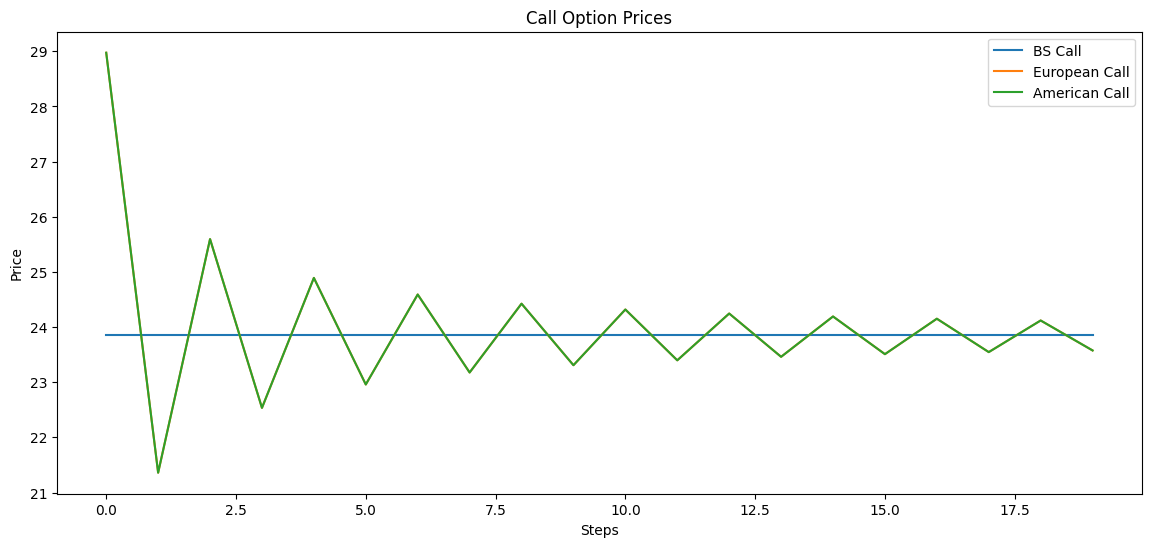

In [30]:
# plot call prices
plt.figure(figsize=(14, 6))
plt.plot(df[['BS_Call', 'European Call', 'American Call']])
plt.title('Call Option Prices')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend(['BS Call', 'European Call', 'American Call'])
plt.show()

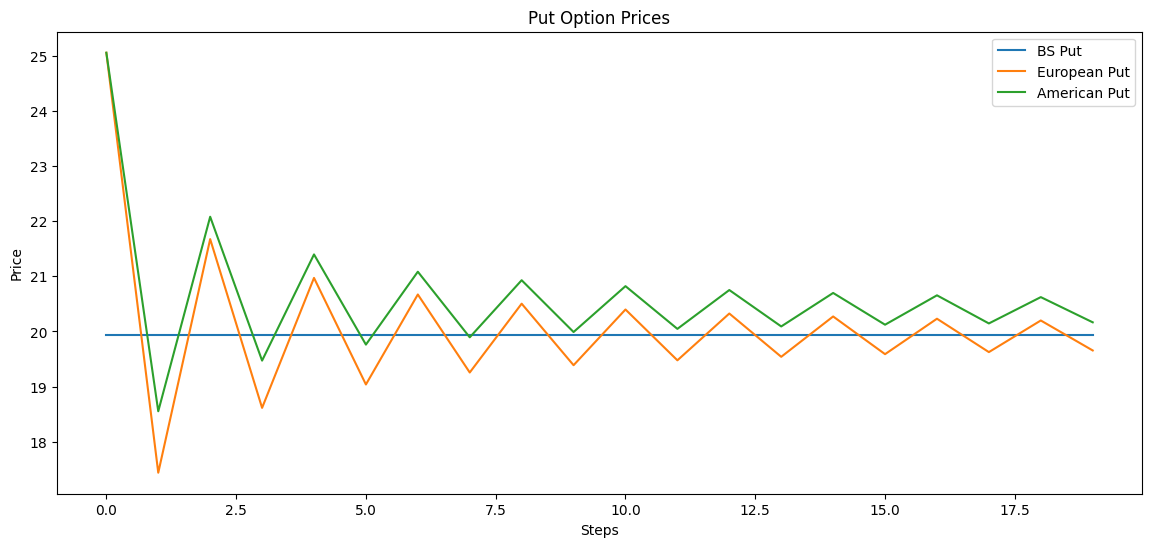

In [31]:
# plot put prices
plt.figure(figsize=(14, 6))
plt.plot(df[['BS_Put', 'European Put', 'American Put']])
plt.title('Put Option Prices')
plt.xlabel('Steps')
plt.ylabel('Price')
plt.legend(['BS Put', 'European Put', 'American Put'])
plt.show()